In [25]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from math import sqrt, log

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os; import json; import fileinput

fileinput.close() # sometimes fileinput is already active
def load_file(filename, max_lines = 150000):
    headers = None
    data = []
    for line in fileinput.input(filename):
        line = line.replace('\n', '')
        # Change separator between ""
        line = re.sub("\"[^\"]*\"", lambda x:x.group(0).replace(',',';'), line)
        line = line.split(',')
        if not headers:
            headers = line
            continue

        data.append(line)
        if len(data) > max_lines: break #and filename != 'test.csv': break
            
    fileinput.close()
    return headers, np.array(data)

h_train, df = load_file("train.csv", max_lines=500000)
df_train = pd.DataFrame(df, columns=h_train).sample(150000)
h_train, df = load_file("test.csv", max_lines=500000)
df_test = pd.DataFrame(df, columns=h_train).sample(150000)

df_train['Dates'] = df_train['Dates'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
#df_train['Resolution'] = df_train['Resolution'].apply(lambda x: x.replace('"', '').split('; '))
df_test['Dates'] = df_test['Dates'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
#df_test['Resolution'] = df_test['Resolution'].apply(lambda x: x.replace('"', '').split('; '))

df_train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

total data:  150000
Index(['X', 'Y', 'day', 'summer', 'fall', 'winter', 'spring', 'X_-122.44',
       'Y_37.76', 'XY', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'year_2008', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'DayOfWeek_Friday',
       'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday',
       'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday',
       'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
       'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
       'PdDistrict_TENDERLOIN', 'IsInterection'],
      dtype='object')
Index(['X', 'Y', 'day', 'summer', 'fall', 'winter', 'spring', 'X_-122.44',
       'Y_37.76', 'XY', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'mont

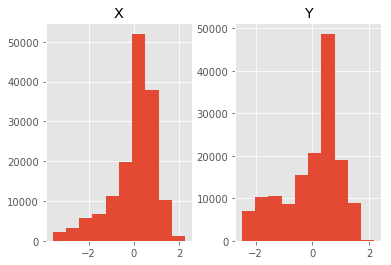

In [28]:
# Feature engineering
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler

def get_season(x):
    summer=0; fall=0; winter=0; spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

def prepare_df(df):
    df['month'] = df['Dates'].apply(lambda x: x.month)
    df['year'] = df['Dates'].apply(lambda x: x.year)
    # don't use .day because test/data set split is from every other 2 weeks of the whole data
    df['day'] = df['Dates'].apply(lambda x: x.day)
    df['X'] = pd.to_numeric(df['X'])
    df['Y'] = pd.to_numeric(df['Y'])
    
    # Season
    df["summer"], df["fall"], df["winter"], df["spring"] = zip(*df["month"].apply(get_season))
    
    """
    N = 10
    DIST = (df['X'].max() - df['X'].min()) / N #0.08 # gives best score
    for lmin in np.arange(df['X'].min(), df['X'].max(), DIST):
        lmax = min(lmin + DIST, df['X'].max())
        df['X_' + str(lmin)] = df['X'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['X_' + str(lmin) + '_NOT'] = df['X'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    DIST = (df['Y'].max() - df['Y'].min()) / N
    for lmin in np.arange(df['Y'].min(), df['Y'].max(), DIST):
        lmax = min(lmin + DIST, df['Y'].max())
        df['Y_' + str(lmin)] = df['Y'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['Y_' + str(lmin) + '_NOT'] = df['Y'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    """
    for lmin, lmax in [(-122.44, -122.40)]:
        df['X_' + str(lmin)] = df['X'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['X_' + str(lmin) + '_NOT'] = df['X'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    for lmin, lmax in [(37.76, 37.79)]:
        df['Y_' + str(lmin)] = df['Y'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['Y_' + str(lmin) + '_NOT'] = df['Y'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    df['XY'] = df['X'] * df['Y']

    # Encode
    df = pd.get_dummies(df, columns=['month', 'year', 'DayOfWeek', 'PdDistrict'])
    # 'Category' will be encoded later
    # This sets two categories as 1 when both are in the column
    #df = df.merge(df['Resolution'].str.join(sep=';').str.get_dummies(sep=';').add_prefix('Res_'), left_index=True, right_index=True)
    #df.drop(['Resolution'], axis=1, inplace=True)
    
    df["IsInterection"] = df["Address"].apply(lambda x: 1 if "/" in x else 0)

    # Memory optimization
    # Technical stuff, contributes nothing to analysis
    conv = df.select_dtypes(include=['int', 'float']).apply(pd.to_numeric,downcast='unsigned')
    df[conv.columns] = conv
    return df

df = prepare_df(df_train.copy(deep=True))
#del df_train # save memory
df_test_sub = prepare_df(df_test.copy(deep=True))
#del df_test # save memory

# Remove rows with wrong X/Y
df = df[df['X'] < -121.5]
df = df[df['Y'] < 60]
xy_scaler = StandardScaler()
xy_scaler.fit(df[["X","Y"]])
df[["X","Y"]] = xy_scaler.transform(df[["X","Y"]])
df_test_sub[["X","Y"]] = xy_scaler.transform(df_test_sub[["X","Y"]])

# Prepare for training
# TODO use address: if intersection or not
X = df.drop(['Category', 'Dates', 'Resolution',
             # Text
             'Address', 'Descript'
              ], axis=1)
#y = pd.get_dummies(df['Category'])
X_test_sub = df_test_sub.drop(['Dates', 'Id',
             # Text
             'Address'
              ], axis=1)
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df['Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print("total data: ", len(X))

df.hist(['X', 'Y'])
print(X.columns)
print(X_test_sub.columns)
#del X_test_sub
#df.info()
#df.head(10)[['Address']]


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, log_loss
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

st = time()
pipe = Pipeline([
    ('scaler', StandardScaler()),
    #('selkbest', SelectKBest(f_regression, k=30)),
    # Score: 0.241
    ('model', LogisticRegression(C=100, max_iter=10, warm_start=True, n_jobs=-1)),
    # Loss: 2.37
    #('model', RandomForestClassifier(n_estimators=20, max_depth=15, warm_start=True, n_jobs=-1))
])

if True:
    pipe.fit(X_train, y_train)
    #y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)
    #preds = np.zeros((len(X_test), len(y_pred_proba)))
    #for i_class in range(0, len(y_pred_proba)):
    #    for i_row in range(0, len(X_test)):
    #        if y_pred_proba[i_class][i_row, 0] < 1:
    #            preds[i_row][i_class] = y_pred_proba[i_class][i_row, 1]
    #        else:
    #            preds[i_row][i_class] = 0
    y_pred = y_pred_proba # preds
    #row = np.zeros(39); row[-2] = 1; y_pred = np.array([row] * len(X_test))
    print("Score:", pipe.score(X_test, y_test))
    #print("Log loss:", log_loss(pd.get_dummies(y_test), y_pred))
    #print(classification_report(y_test, y_pred))

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        #'selkbest__k': [30, 35, 40],
        #'model__max_iter': [50, 100, 200],
        #'model__warm_start': [True, False]
        #'model__C': [1e2, 1e3, 1e1, 1e0]
        #'model__max_features': [20]
                 }
    grid = GridSearchCV(pipe, param_grid, cv=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    
print('Done in {:.2f} min.'.format((time() - st)/60))

Score: 0.2419
Done in 1.18 min.


In [22]:
#print((y_pred_proba[0]))
#print((np.array(pd.get_dummies(y_test))[0]))

features = {}
try:
    #scores = pipe.named_steps['model'].feature_importances_
    scores = np.absolute(pipe.named_steps['model'].coef_).sum(axis=0)
    i=0
    for col in X.columns:
        features[col] = scores[i]
        i+=1     
except Exception as e:
    print(e)
    pass

# Print the best ones
import operator
features_sorted = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
for f, v in features_sorted: #[:50]:
    print("{}: {:.5f}".format(f, v))
#features_sorted

IsInterection: 17.40032
X: 8.24919
Y: 8.13456
Y_37.76: 8.04578
PdDistrict_RICHMOND: 8.03558
XY: 7.79446
PdDistrict_TARAVAL: 7.28872
PdDistrict_TENDERLOIN: 6.74214
X_-122.44: 6.73372
PdDistrict_INGLESIDE: 6.27799
PdDistrict_PARK: 6.22847
PdDistrict_MISSION: 5.94689
PdDistrict_NORTHERN: 5.73099
PdDistrict_BAYVIEW: 5.69717
PdDistrict_SOUTHERN: 5.63058
year_2014: 5.39811
year_2015: 5.15791
year_2011: 5.02591
year_2012: 4.33359
year_2013: 4.24037
PdDistrict_CENTRAL: 4.05119
DayOfWeek_Saturday: 3.99866
DayOfWeek_Sunday: 3.51088
day: 3.45662
month_2: 3.23154
month_12: 3.15201
month_6: 3.12470
month_10: 3.10831
DayOfWeek_Monday: 3.08360
month_8: 2.81523
month_1: 2.81266
month_9: 2.79445
month_3: 2.79364
month_7: 2.79152
month_5: 2.77332
DayOfWeek_Wednesday: 2.75443
month_11: 2.68317
DayOfWeek_Tuesday: 2.68274
month_4: 2.46662
DayOfWeek_Thursday: 2.04790
spring: 1.90401
DayOfWeek_Friday: 1.82785
winter: 1.68062
summer: 1.53004
fall: 1.52834


In [8]:
# For submission
st = time()
pipe.fit(X, y)
print('{:.2f} min. trained'.format((time() - st)/60))
#y_pred_sub = pipe.predict(X_test_sub)
y_pred_proba = pipe.predict_proba(X_test_sub)
#preds = np.zeros((len(X_test_sub), len(y_pred_proba)))
#for i_class in range(0, len(y_pred_proba)):
#    for i_row in range(0, len(X_test)):
#        if y_pred_proba[i_class][i_row, 0] < 1:
#            preds[i_row][i_class] = y_pred_proba[i_class][i_row, 1]
#        else:
#            preds[i_row][i_class] = 0
y_pred_sub = y_pred_proba # preds
print('{:.2f} min. done.'.format((time() - st)/60))

11.55 min. trained
11.58 min. done.


In [9]:
columns = 'Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS'.split(',')
print(len(columns))
print(len(y_pred_sub[0]))
ids = list(range(0, len(df_test_sub)))

import csv
csvfile = open('submission.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(columns)
for i in range(0, len(df_test_sub)):
    if i%300000==0: print("{:.0f}%".format(i / len(df_test_sub) * 100))
    row = y_pred_sub[i].round(decimals=6) # round to reduce size of submission.csv
    writer.writerow([i] + list(row))

csvfile.close()
print("Finished.")

40
39
0%
34%
68%
Finished.
